<a href="https://colab.research.google.com/github/c-mmonteiro/t1-algo-feature/blob/main/ConformalPrediction_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aplicação de LSTM e Conformal Prediction
Carlos Monteiro


In [20]:
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Tuple, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi



from __future__ import annotations
import math
from dataclasses import dataclass
from typing import Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler

import yfinance as yf
from datetime import datetime, timedelta


# 1. Preparação dos dados

## 1.1 Gerar Dados

In [2]:

ticker = "PETR4.SA"
end_date = datetime.today()
start_date = end_date - timedelta(days=20*365)


df = yf.download(
    ticker,
    start=start_date.strftime('%Y-%m-%d'),
    end=end_date.strftime('%Y-%m-%d'),
    interval="1d",
    auto_adjust=False,   # Mantém OHLC originais
    progress=False
)

df


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
Date,,,,,,
2006-01-09,4.027728,20.420000,20.650000,20.180000,20.344999,8782200
2006-01-10,4.034631,20.455000,20.625000,20.225000,20.455000,13541600
2006-01-11,4.171715,21.150000,21.225000,20.605000,20.625000,15117800
2006-01-12,4.206233,21.325001,21.795000,20.950001,21.145000,16237800
2006-01-13,4.201301,21.299999,21.620001,21.080000,21.424999,7932600
...,...,...,...,...,...,...
2025-12-23,30.309999,30.309999,30.570000,30.200001,30.549999,35703900
2025-12-26,30.410000,30.410000,30.430000,30.120001,30.309999,20178600


In [3]:
df.columns = [col[0] for col in df.columns]
df.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [4]:
df = df.drop(columns=['Adj Close'])

In [5]:
df['y'] = (df['Close'].diff(periods=-1))*-1
display(df.head())

,Close,High,Low,Open,Volume,y
Date,,,,,,
2006-01-09,20.420000,20.650000,20.180000,20.344999,8782200,0.035000
2006-01-10,20.455000,20.625000,20.225000,20.455000,13541600,0.695000
2006-01-11,21.150000,21.225000,20.605000,20.625000,15117800,0.175001
2006-01-12,21.325001,21.795000,20.950001,21.145000,16237800,-0.025002
2006-01-13,21.299999,21.620001,21.080000,21.424999,7932600,0.425001


In [6]:
print(df.isnull().sum())
df.dropna(inplace=True)

Close     0
High      0
Low       0
Open      0
Volume    0
y         1
dtype: int64


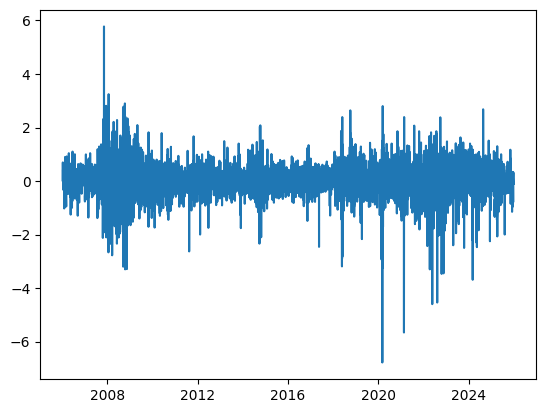

In [7]:
plt.plot(df['y'])

## 1.2 Scaling and Deframing

In [8]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled.head()

,Close,High,Low,Open,Volume,y
0,0.335748,0.331512,0.335773,0.333712,0.006573,0.542812
1,0.336473,0.331006,0.336713,0.335986,0.010136,0.595380
2,0.350859,0.343149,0.344658,0.339500,0.011315,0.553963
3,0.354482,0.354685,0.351871,0.350248,0.012154,0.538032
4,0.353964,0.351144,0.354589,0.356036,0.005937,0.573875


Features shape: (1, 4969, 5), Targets shape: (1, 4969, 1)


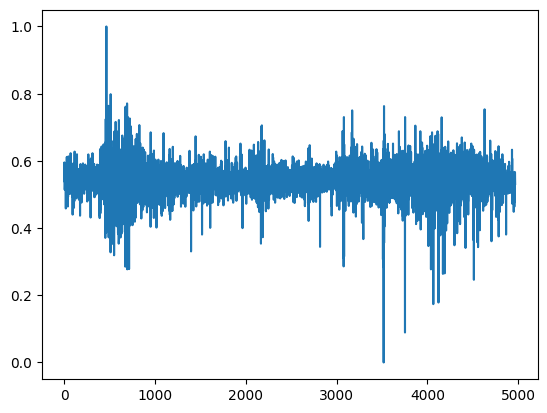

In [12]:
columns_features = [col for col in df.columns if not col.startswith('y')]
n_features = len(columns_features)
n_samples = len(df)

X = df_scaled[columns_features].values.astype(np.float32).reshape(1, -1, n_features)

y = df_scaled['y'].values.astype(np.float32).reshape(1, -1, 1)


print(f"Features shape: {X.shape}, Targets shape: {y.shape}")
plt.plot(y[0,:,0])



## 1.3 Criar janela de entrada e de previsão em um dataset

In [13]:
class WindowedTS(Dataset):
    """
    PyTorch Dataset for sliding window forecasting.

    CONCEPT: Long time series → many overlapping windows

    Example with history=3, forecast=2:
      Series: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

      Window 1: history=[0,1,2], forecast=[3,4]
      Window 2: history=[1,2,3], forecast=[4,5]
      Window 3: history=[2,3,4], forecast=[5,6]
      ... and so on

    This creates many training examples from a single long series!

    Returns (for each window):
        Xw: Historical features [history_len, n_features]
        y_in: Decoder inputs (teacher forcing) [forecast_len, 1]
              First token = 0 (start token)
              Remaining tokens = shifted ground-truth targets
        y_true: Ground-truth future targets [forecast_len, 1]

    Args:
        X: All features [n_series, series_length, n_features]
        y: All targets [n_series, series_length, 1]
        T_x: History length (how much past to use)
        T_y: Forecast horizon (how far ahead to predict)
    """
    def __init__(self, X, y, T_x: int, T_y: int):
        self.X = X
        self.y = y
        self.T_x = T_x  # History window size
        self.T_y = T_y  # Forecast horizon
        self.length = X.shape[1]

        # BUILD INDEX: list of all valid (series_id, start_time) pairs
        self.index = []
        for i in range(X.shape[0]):  # For each series
            # For each valid starting position
            for t in range(self.length - (T_x + T_y) + 1):
                self.index.append((i, t))

        # Total windows = n_series * (series_length - T_x - T_y + 1)

    def __len__(self):
        return len(self.index)

    def __getitem__(self, idx):
        """
        Extract one training window.

        Returns:
            Xw: Historical window [T_x, n_features]
            y_in: Decoder inputs [T_y, 1] (shifted targets with start token)
            y_future: Ground-truth targets [T_y, 1]
        """
        i, t = self.index[idx]  # Which series, which starting time

        # EXTRACT HISTORY
        Xw = self.X[i, t:t+self.T_x, :].copy()  # [T_x, n_features]

        # EXTRACT FUTURE TARGETS
        y_future = self.y[i, t+self.T_x:t+self.T_x+self.T_y, :].copy()  # [T_y, 1]

        # CREATE TEACHER FORCING INPUTS (shifted right by 1)
        y_in = np.zeros((self.T_y, 1), dtype=np.float32)
        y_in[1:, 0] = y_future[:-1, 0]  # Shift: positions 1..T_y get targets 0..T_y-1
        # y_in[0] = 0 (start token)

        return torch.from_numpy(Xw), torch.from_numpy(y_in), torch.from_numpy(y_future)

In [14]:
T_X = 32
T_Y = 8
ds = WindowedTS(X, y, T_x=T_X, T_y=T_Y)
print(f"Total windows: {len(ds)} (history={T_X}, forecast={T_Y})")

Total windows: 4930 (history=32, forecast=8)


## 1.7 Separa em treino, validação e test e Cria dataloader

In [35]:
BATCH = 64

val_idx = int(len(ds)*0.6)
test_idx = int(len(ds)*0.8)

train_ds = Subset(ds, list(range(val_idx)))
val_ds = Subset(ds, list(range(val_idx, test_idx)))
test_ds = Subset(ds, list(range(test_idx, len(ds))))

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds, batch_size=BATCH, shuffle=False, drop_last=False)

# 2. Aplicação dos modelos

### Pré-seting

In [36]:
# =============================================================================
#                       0) RUNTIME / DEVICE SETTINGS
# =============================================================================
# PEDAGOGICAL NOTE: Modern deep learning leverages GPU acceleration.
# This section configures PyTorch to use CUDA (NVIDIA GPUs) if available.

# Automatically detect and use GPU if available, otherwise fall back to CPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if DEVICE == "cuda":
    # Enable cuDNN autotuner: finds the fastest convolution algorithms for your hardware
    # (Not critical for Transformers, but good practice for CNNs)
    torch.backends.cudnn.benchmark = True

    # Use TensorFloat-32 (TF32) for faster matrix multiplications on Ampere+ GPUs
    # TF32 trades a tiny bit of precision for ~8x speed improvement
    try:
        torch.set_float32_matmul_precision("high")  # options: "highest", "high", "medium"
    except Exception:
        pass  # Older PyTorch versions don't support this

# MIXED PRECISION TRAINING SETUP
# Why? Training in 16-bit (half precision) is ~2x faster and uses less memory
# than 32-bit (full precision), with minimal accuracy loss.
USE_AMP = (DEVICE == "cuda")                                 # Enable AMP only on GPU
USE_BF16 = USE_AMP and torch.cuda.is_bf16_supported()        # BFloat16 is more stable than Float16
AMP_DTYPE = torch.bfloat16 if USE_BF16 else torch.float16    # Choose precision for autocast
SCALER_ENABLED = USE_AMP and (not USE_BF16)                  # GradScaler only needed for fp16

# REPRODUCIBILITY: Set random seeds for consistent results across runs
# Important for teaching: students can reproduce exact results
torch.manual_seed(7)
np.random.seed(7)

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


## 2.1 LSTM

### Definição da função

In [40]:
class TS_LSTM(nn.Module):
    def __init__(self, input_size=30, step_ahead=10, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, step_ahead)
        self.to(DEVICE)
        self.step_ahead = step_ahead

    def forward(self, x):
        batch_size = x.size(0)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out.view(batch_size, self.step_ahead, 1)

    def fit(self, loader, n_epochs=20, lr=0.001):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        loss_fn = nn.MSELoss()

        for epoch in range(n_epochs):
            epoch_loss = 0.0
            for X_batch, _, y_batch in loader:
                optimizer.zero_grad()
                y_pred = self(X_batch.to(DEVICE))
                loss = loss_fn(y_pred.squeeze(), y_batch.squeeze().to(DEVICE))
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            epoch_loss /= len(loader.dataset)
            print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.6f}")

    def predict(self, X):
        DEVICE = next(self.parameters()).device
        self.eval()  # Set to evaluation mode

        with torch.no_grad():
            # Use only first sample for visualization
            Xb = X.to(DEVICE).float()      # [1, T_x, features]

            # Generate forecast
            pred = self(Xb).float()

        # Convert to numpy for plotting
        pr = pred[0, :, 0].detach().cpu().numpy()   # Prediction

        return pr

    def predict_evaluation(self, test_loader):

      DEVICE = next(self.parameters()).device
      self.eval()  # Set to evaluation mode

      with torch.no_grad():
          # Get one batch from validation set
          Xb_cpu, _, ytrue_cpu = next(iter(test_loader))

          # Use only first sample for visualization
          Xb = Xb_cpu[:1].to(DEVICE).float()      # [1, T_x, features]
          ytrue = ytrue_cpu[:1].to(DEVICE).float()  # [1, T_y, 1]

          # Generate forecast
          pred = self(Xb).float()

      # Convert to numpy for plotting
      gt = ytrue[0, :, 0].detach().cpu().numpy()  # Ground truth
      pr = pred[0, :, 0].detach().cpu().numpy()   # Prediction

      # Compute error metrics
      mae = np.mean(np.abs(pr - gt))              # Mean Absolute Error
      rmse = np.sqrt(np.mean((pr - gt) ** 2))     # Root Mean Squared Error

      return mae, rmse

### Chamada da Função

In [41]:
model_lstm = TS_LSTM(input_size=5, step_ahead=T_Y, hidden_size=64, num_layers=2)
model_lstm.fit(train_loader, n_epochs=30, lr=0.001)

Epoch 1/30, Loss: 0.001019
Epoch 2/30, Loss: 0.000040
Epoch 3/30, Loss: 0.000036
Epoch 4/30, Loss: 0.000035
Epoch 5/30, Loss: 0.000034
Epoch 6/30, Loss: 0.000035
Epoch 7/30, Loss: 0.000034
Epoch 8/30, Loss: 0.000034
Epoch 9/30, Loss: 0.000034
Epoch 10/30, Loss: 0.000034
Epoch 11/30, Loss: 0.000034
Epoch 12/30, Loss: 0.000035
Epoch 13/30, Loss: 0.000035
Epoch 14/30, Loss: 0.000035
Epoch 15/30, Loss: 0.000035
Epoch 16/30, Loss: 0.000034
Epoch 17/30, Loss: 0.000035
Epoch 18/30, Loss: 0.000034
Epoch 19/30, Loss: 0.000035
Epoch 20/30, Loss: 0.000034
Epoch 21/30, Loss: 0.000034
Epoch 22/30, Loss: 0.000035
Epoch 23/30, Loss: 0.000035
Epoch 24/30, Loss: 0.000035
Epoch 25/30, Loss: 0.000035
Epoch 26/30, Loss: 0.000035
Epoch 27/30, Loss: 0.000035
Epoch 28/30, Loss: 0.000035
Epoch 29/30, Loss: 0.000035
Epoch 30/30, Loss: 0.000035


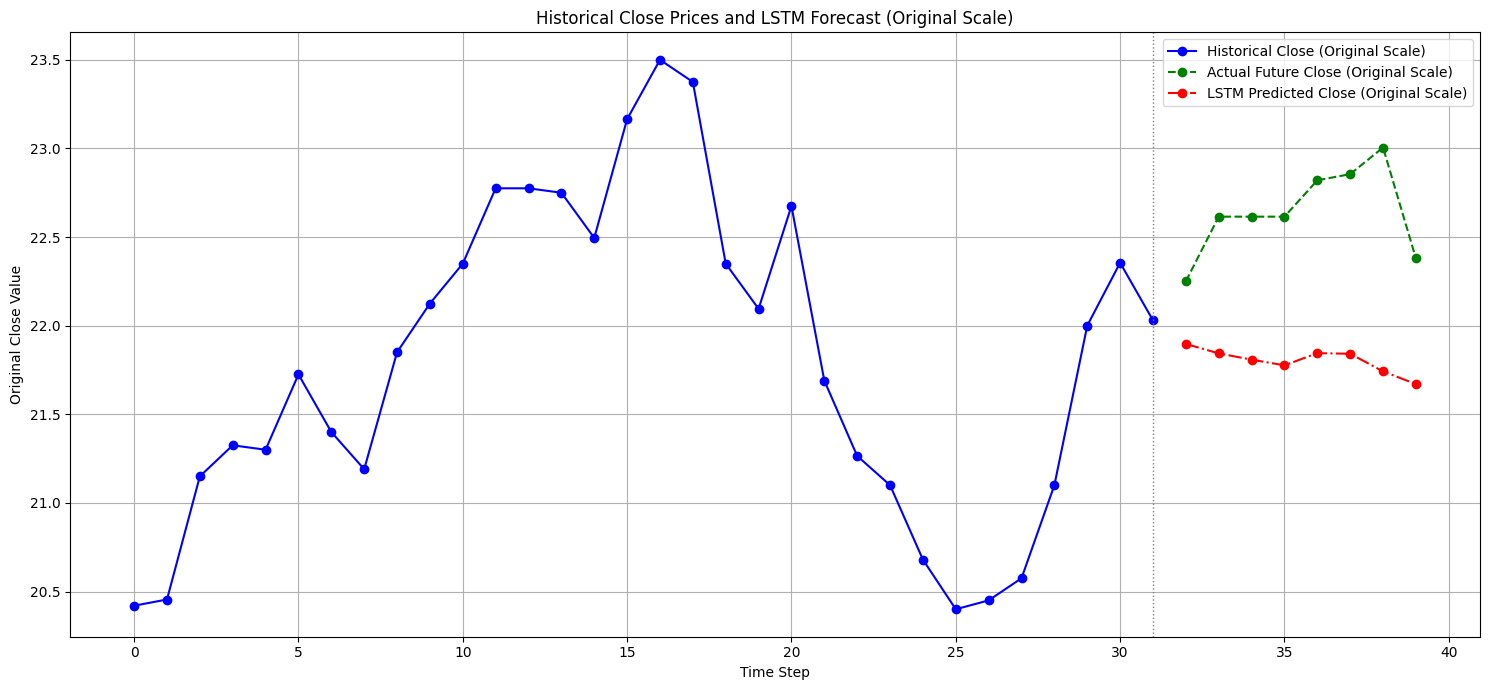

In [54]:
history_features, decoder_inputs, future_targets = ds[0]

prediction = model_lstm.predict(history_features.unsqueeze(0))

# --- Inverse Scaling for Close history, Predictions (diff) and Future Targets (diff) ---

# Get the total number of features the scaler was fitted on (Close, High, Low, Open, Volume, y)
n_features_total = len(df.columns) # This is 6
n_features_X = len(columns_features) # This is 5

# 1. Inverse scale the 'Close' values from history_features (index 0 of features)
scaled_history_close = history_features[:, 0].numpy() # Extract scaled 'Close' column
dummy_array_history_close = np.zeros((T_X, n_features_total), dtype=np.float32)
dummy_array_history_close[:, 0] = scaled_history_close # Place scaled 'Close' in the first column
original_history_close = scaler.inverse_transform(dummy_array_history_close)[:, 0]

# 2. Inverse scale the prediction (which are scaled 'y' differences)
dummy_array_pred_diff = np.zeros((T_Y, n_features_total), dtype=np.float32)
dummy_array_pred_diff[:, -1] = prediction.flatten() # Place scaled predictions in the 'y' column (last)
original_prediction_diff = scaler.inverse_transform(dummy_array_pred_diff)[:, -1]

# 3. Inverse scale the future targets (which are scaled 'y' differences)
future_targets_np = future_targets.numpy().flatten()
dummy_array_targets_diff = np.zeros((T_Y, n_features_total), dtype=np.float32)
dummy_array_targets_diff[:, -1] = future_targets_np # Place scaled targets in the 'y' column
original_future_targets_diff = scaler.inverse_transform(dummy_array_targets_diff)[:, -1]


last_historical_close = original_history_close[-1]
cumulative_prediction_prices = np.cumsum(original_prediction_diff) + last_historical_close
cumulative_future_prices = np.cumsum(original_future_targets_diff) + last_historical_close


plt.figure(figsize=(15, 7))
plt.plot(np.arange(T_X), original_history_close, label='Historical Close (Original Scale)', color='blue', marker='o')
plt.plot(np.arange(T_X, T_X + T_Y), cumulative_future_prices, label='Actual Future Close (Original Scale)', color='green', linestyle='--', marker='o')
plt.plot(np.arange(T_X, T_X + T_Y), cumulative_prediction_prices, label='LSTM Predicted Close (Original Scale)', color='red', linestyle='-.', marker='o')

plt.title('Historical Close Prices and LSTM Forecast (Original Scale)')
plt.xlabel('Time Step')
plt.ylabel('Original Close Value')
plt.legend()
plt.grid(True)
plt.axvline(x=T_X-1, color='gray', linestyle=':', linewidth=1, label='Forecast Start')
plt.tight_layout()
plt.show()